In [42]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms, models
import importlib as il
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from torch.utils.data.sampler import Sampler
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn as nn
import torch.optim as optim
import classification_methods as clm
from mlcm import mlcm
import seaborn as sns

import importlib as il

il.reload(clm)

folder_path = './labels'
combined_df = clm.read_and_combine_csvs(folder_path)

# print(combined_df.head())
group_data = clm.read_csvs_by_group(folder_path)

# Class names 
label_names = [
    "leichte durchscheinende Füllung", 
    "mittlere durchscheinende Füllung", 
    "starke durchscheinende Füllung", 
    "Bläschen", 
    "Füllung über Rand hinaus", 
    "Kratzer/Späne auf Deckel",
    "Zelle falsch erkannt", 
    "small bright area on upper border", 
    "sonstiger Fehler"
]

Total groups read: 15


In [ ]:
# Sum the frequency of each label
label_frequencies = combined_df.iloc[:, 1:].sum()

# Display the label frequencies
print(label_frequencies)

# Plot the histogram
plt.figure(figsize=(12, 6))
label_frequencies.plot(kind='bar')
plt.title('Frequency of Each Label')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

label_frequencies_by_group = clm.extract_label_frequencies(group_data)
# Plot the interactive box plot
clm.plot_interactive_box_plot(label_frequencies_by_group)


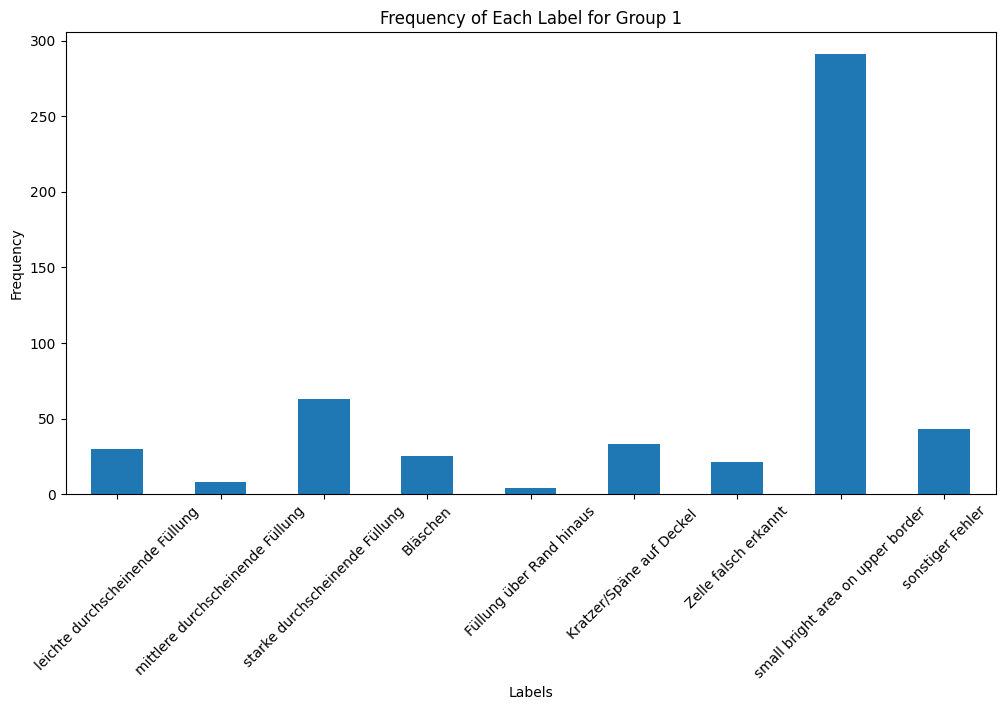

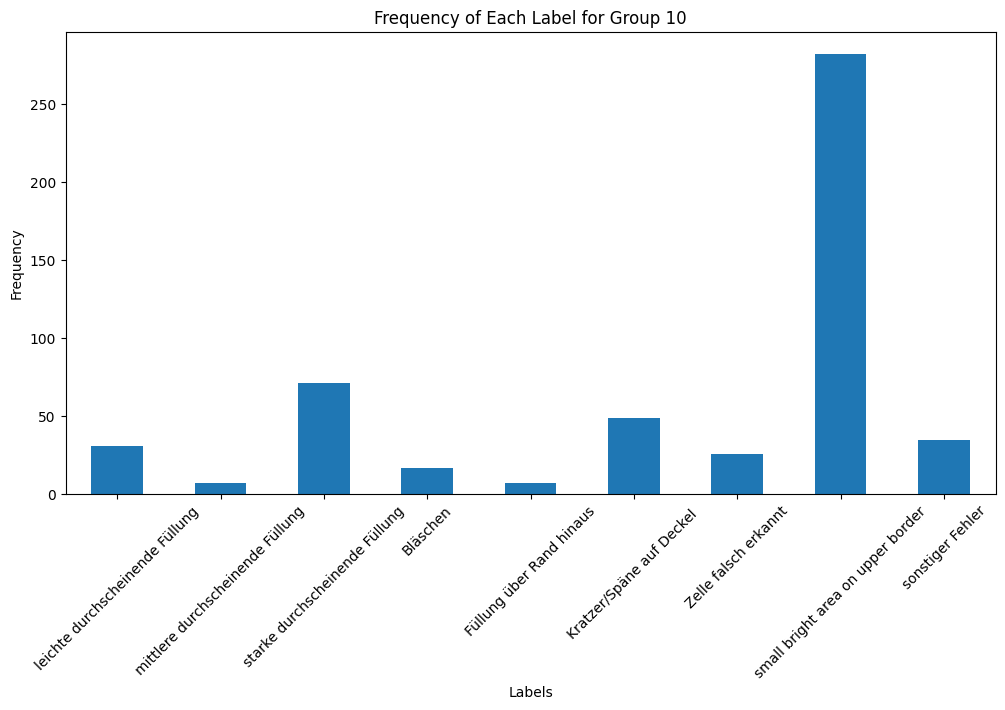

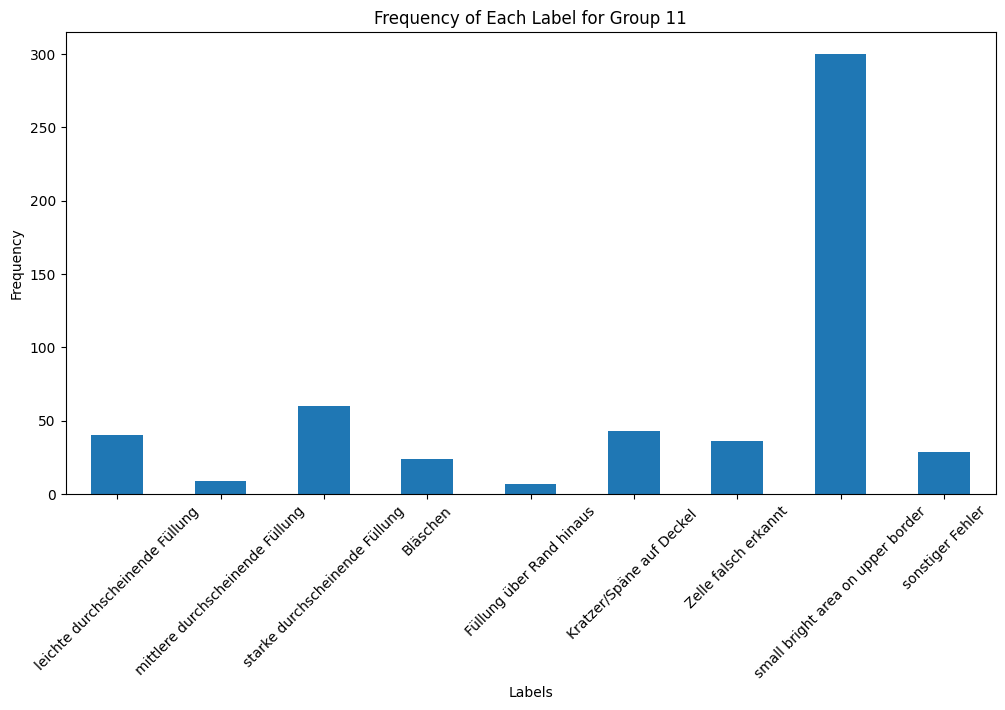

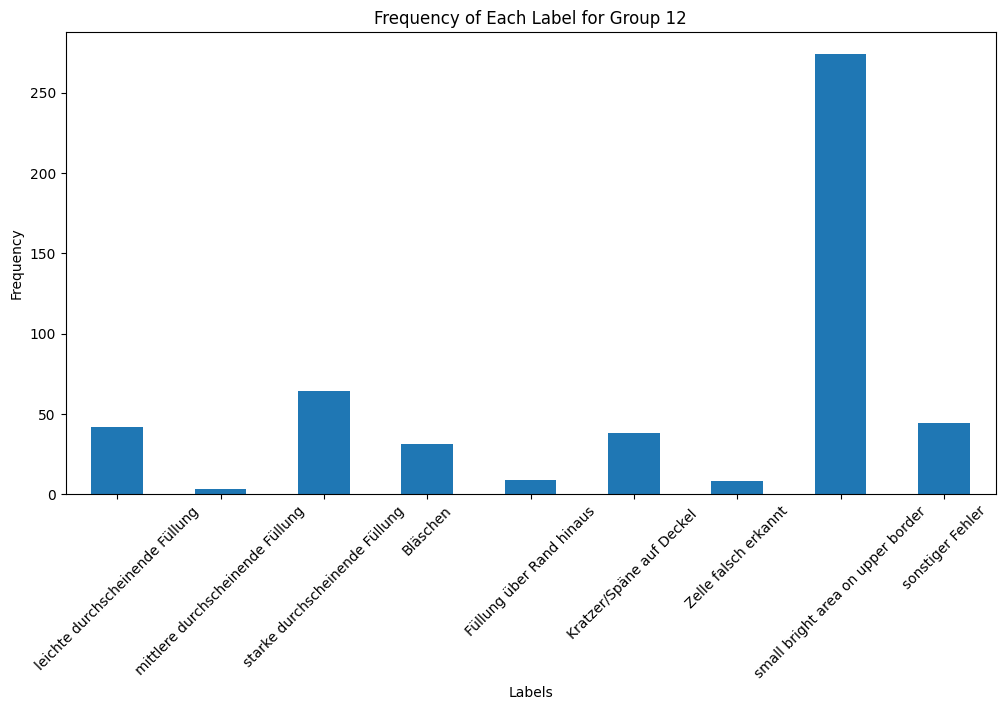

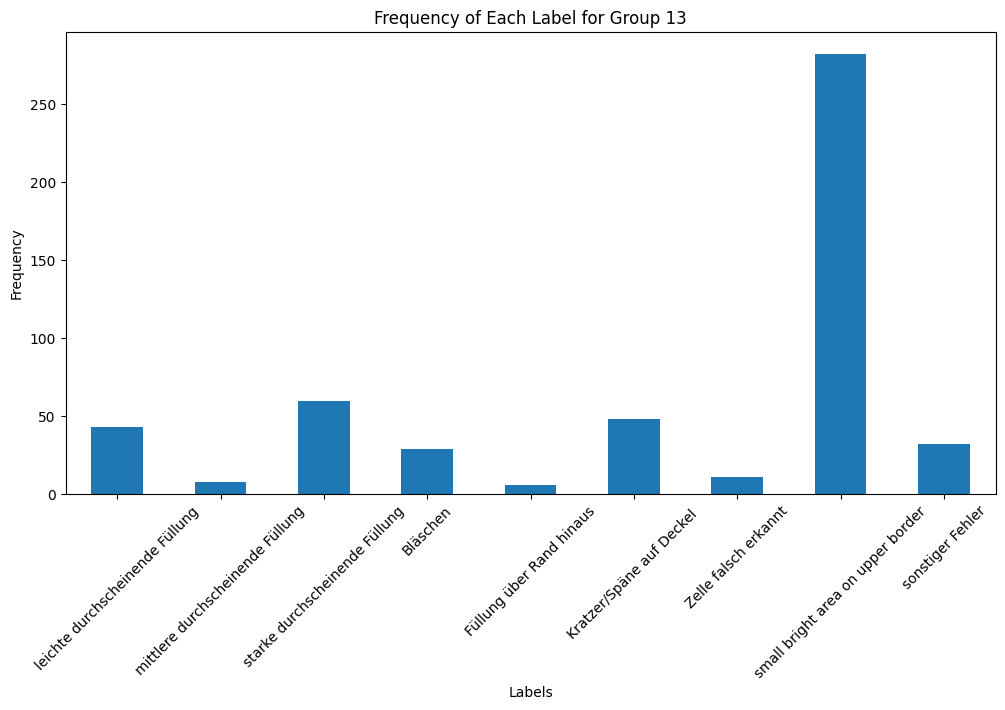

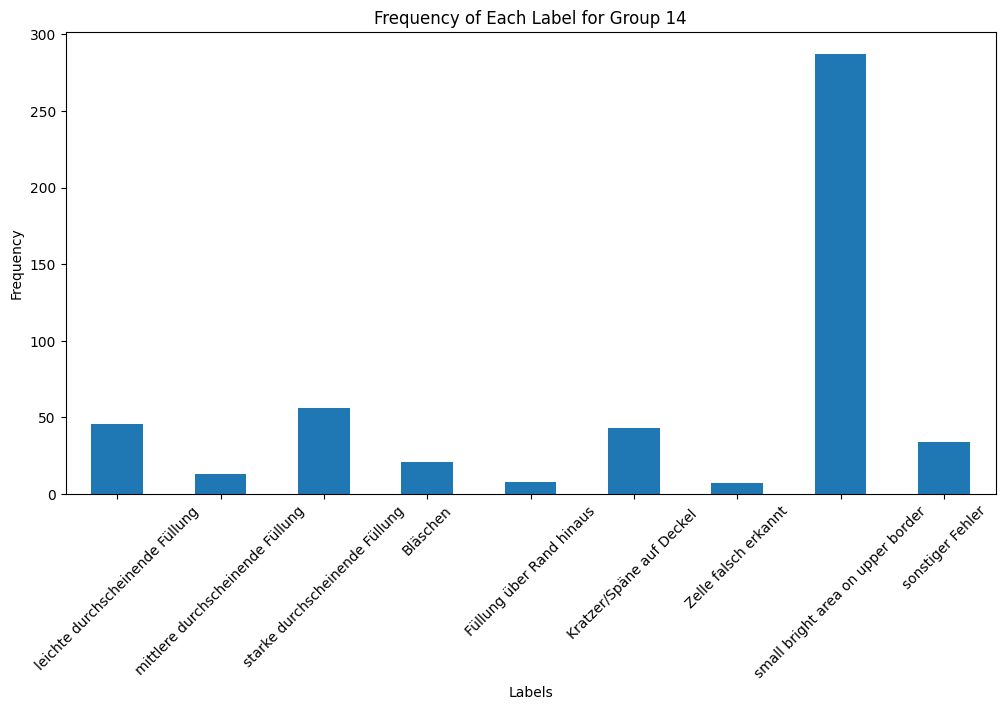

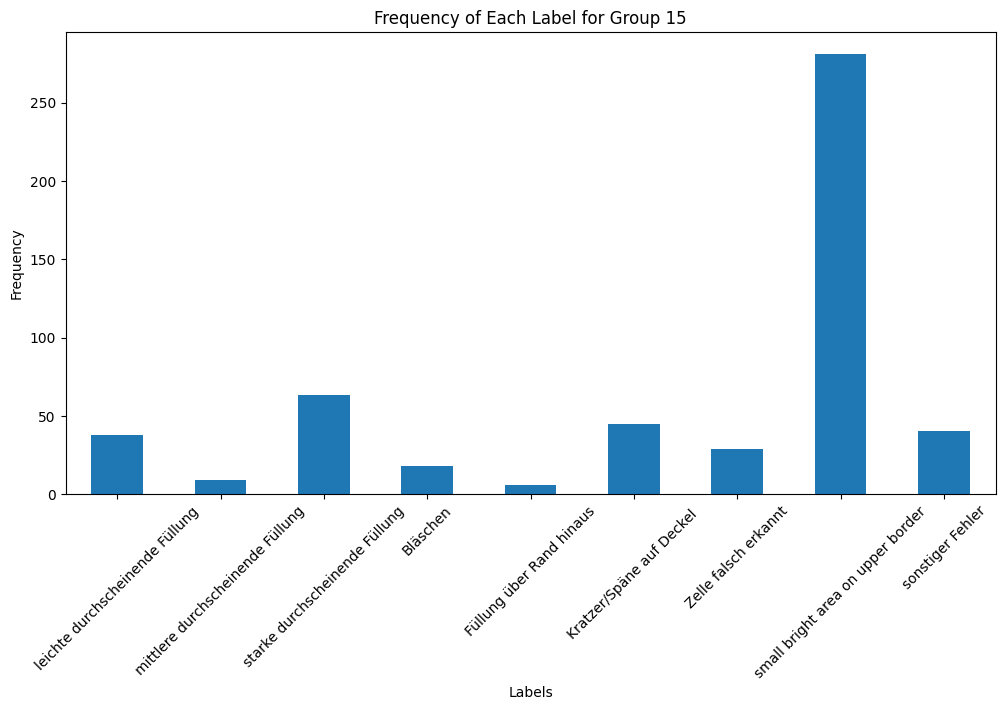

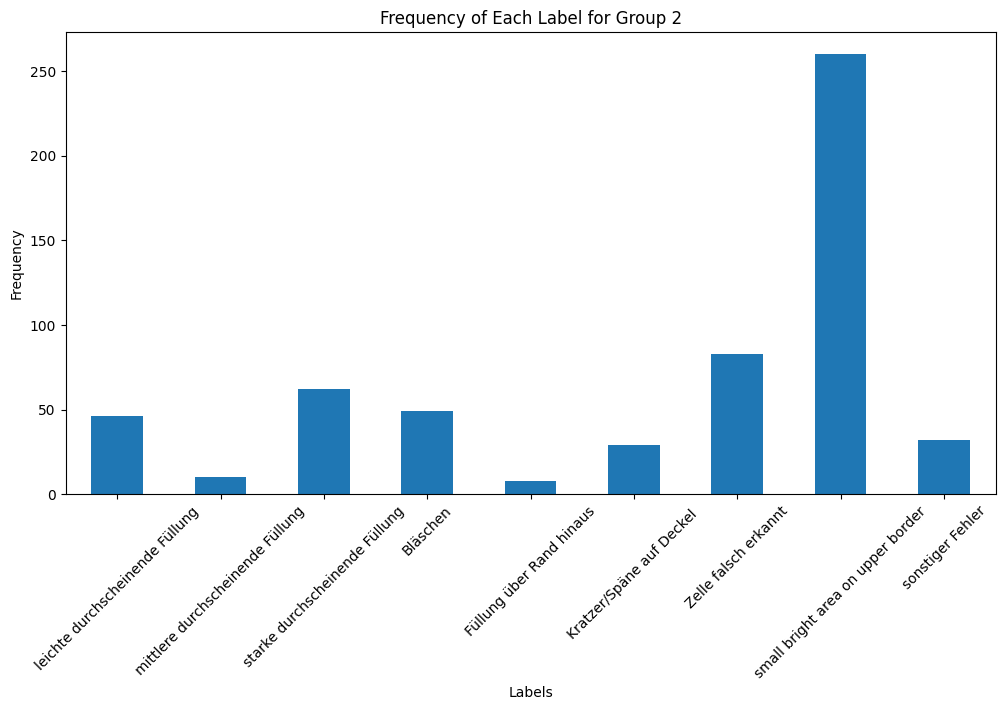

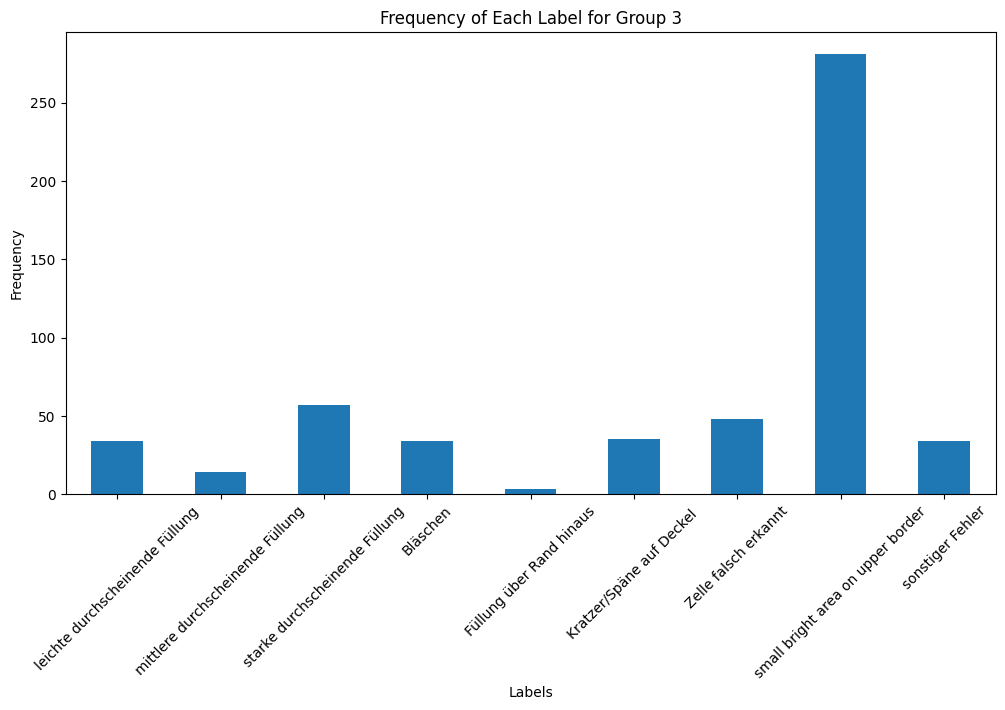

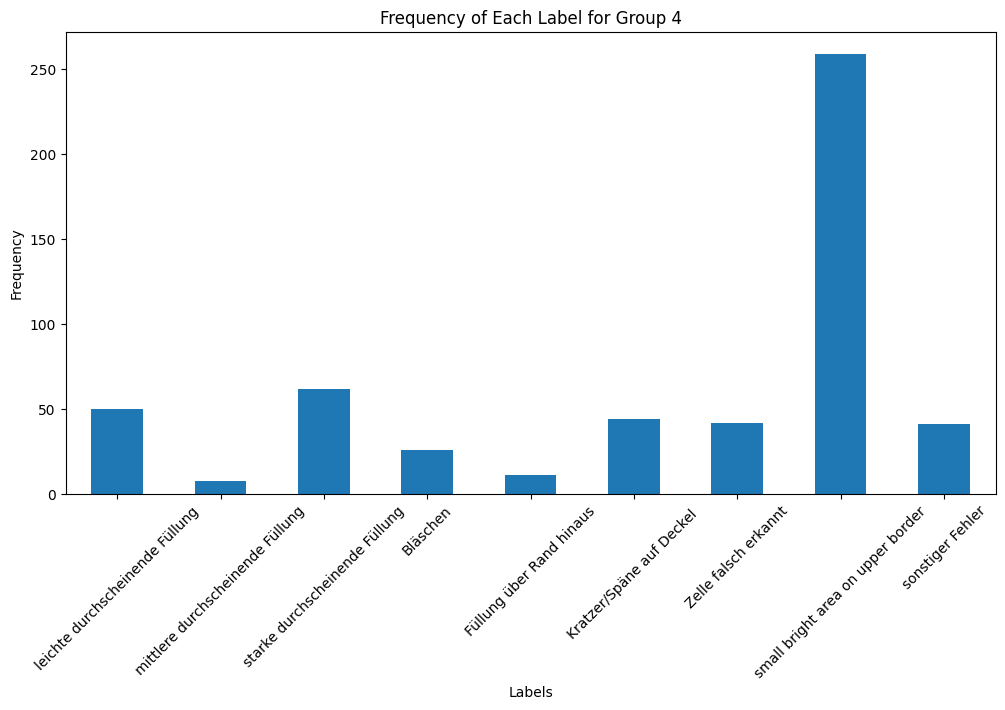

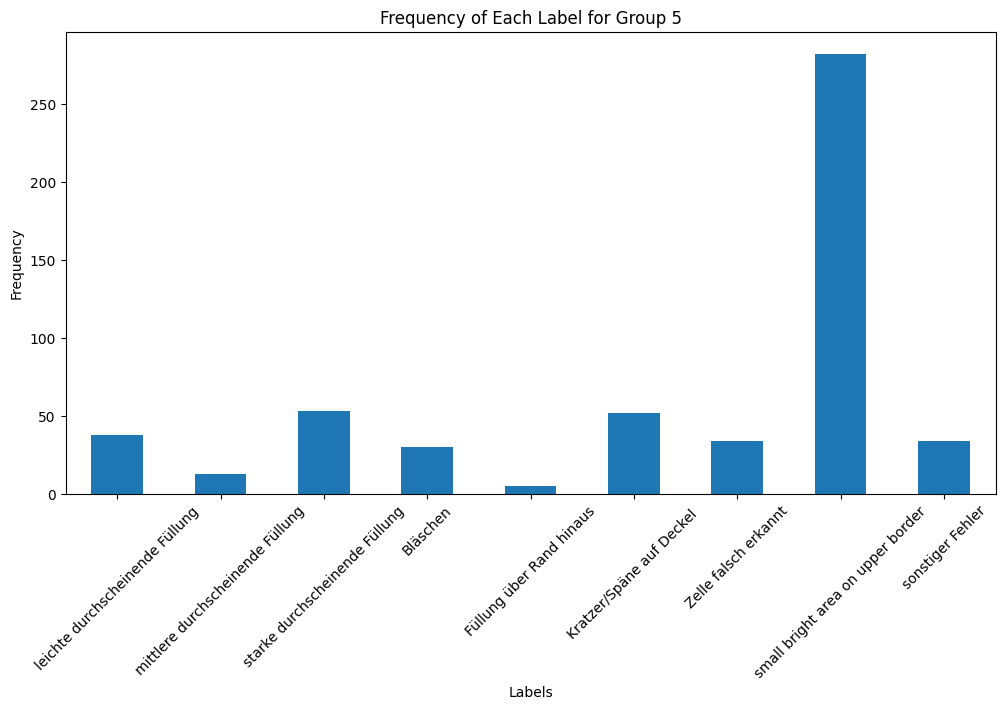

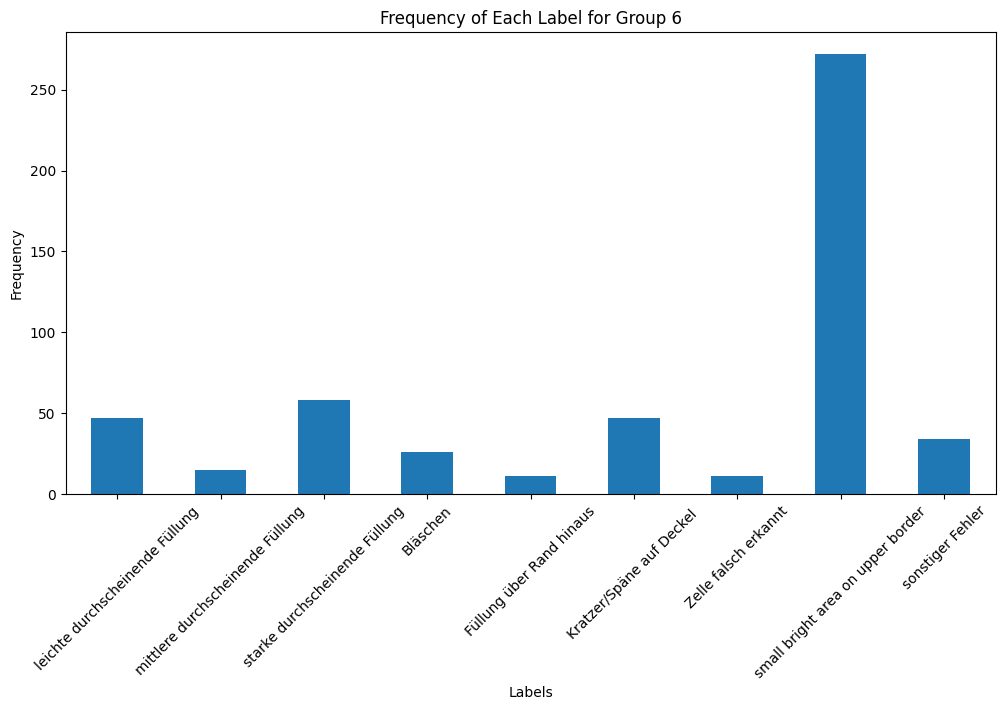

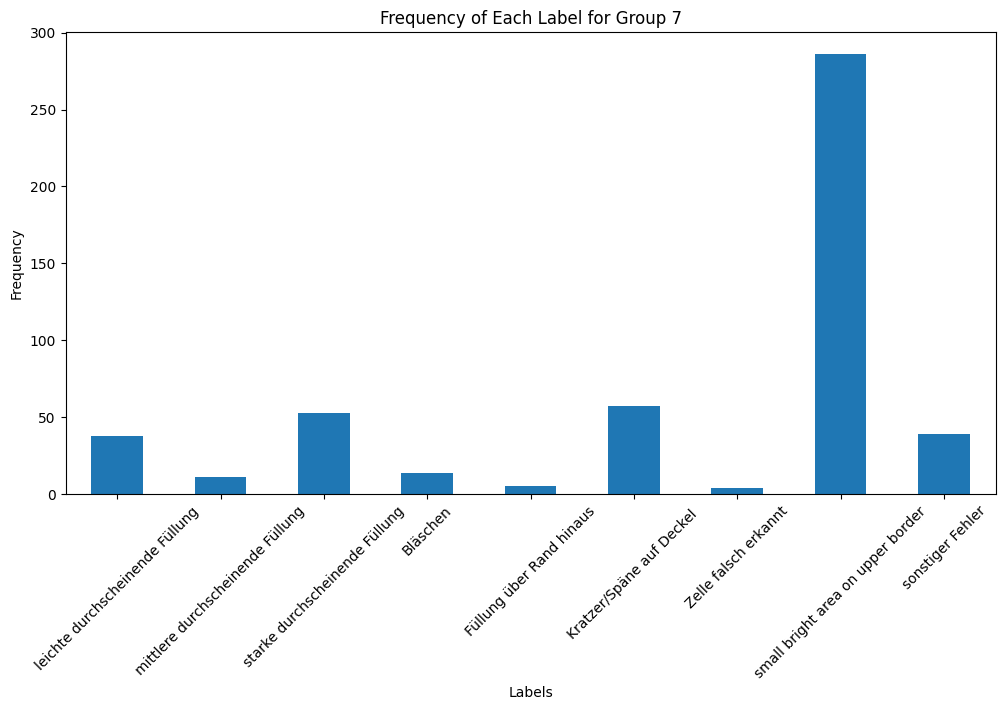

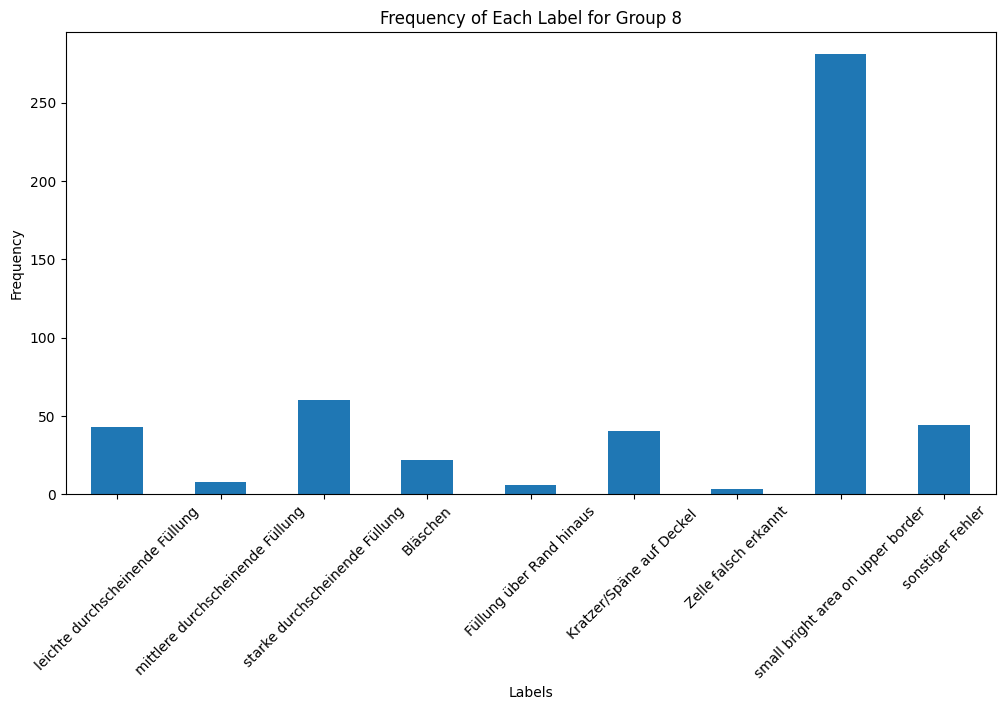

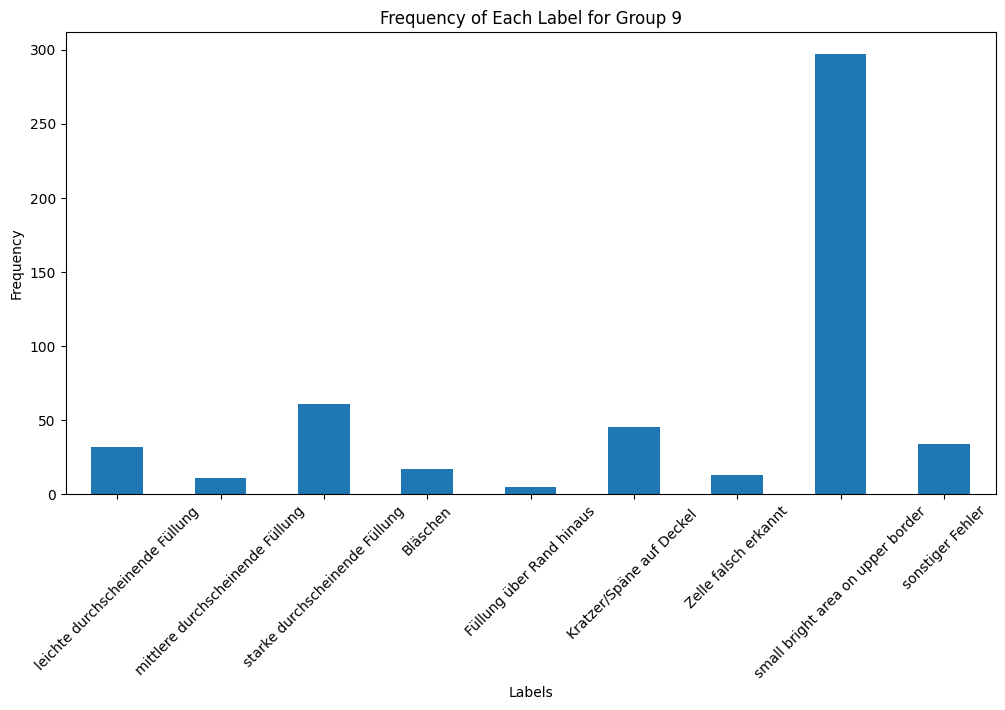

In [61]:
# Plot histograms for each group
clm.plot_histograms_for_groups(group_data)


In [45]:
il.reload(clm)
image_dir = './results' 
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_type = 'ResNet50'  # Choose 'ResNet50' or 'ChocolateCNN' or 'ImprovedCNN'
num_epochs=20
learning_rate=0.001

if model_type == 'ChocolateCNN':
    input_size = (100, 25)  # Adjusted for ChocolateCNN input size
    model = clm.ChocolateCNN().to(device)
elif model_type == 'ImprovedCNN':
    input_size = (100, 25)  # Adjusted for ImprovedCNN input size
    model = clm.ImprovedCNN().to(device)
elif model_type == 'ResNet50':
    input_size = (224, 224)  # ResNet-50 expects 224x224 images
    model = clm.get_resnet50_model().to(device)
else:
    raise ValueError("Invalid model type. Choose 'ChocolateCNN' or 'ResNet50' or 'ImprovedCNN'.")

# Get data loaders
train_loader, val_loader, val_indices = clm.get_data_loaders(image_dir, input_size, combined_df)

Using device: cuda


In [ ]:
il.reload(clm)
# Get a batch from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)  

# Convert labels to numpy array
labels_np = labels.numpy()

# Sum across the batch axis (axis=0) to get the count of each label
label_counts = np.sum(labels_np, axis=0)

# Print the label distribution in the batch
print("Label distribution in the batch (multi-label):")
for idx, count in enumerate(label_counts):
    print(f"Label {idx}: {int(count)} samples")

In [ ]:

il.reload(clm)
 # Train the model
model, optimizer, avg_train_loss, avg_val_loss, accuracy, hard_accuracy, train_losses, val_losses, cm, misclassified_images = clm.train_model1(device, model, train_loader, val_loader, num_epochs, learning_rate)

In [50]:
il.reload(clm)
# Define the save path
save_path = 'classification_models/ResNet50_5.pth'

# Create the directory if it does not exist

os.makedirs('classification_models', exist_ok=True)

clm.save_model(model, optimizer, num_epochs, avg_train_loss, avg_val_loss, accuracy, hard_accuracy, train_losses, val_losses, cm, val_indices, misclassified_images, save_path)

Model saved successfully as ResNet at classification_models/ResNet50_5.pth


In [ ]:
il.reload(clm)
# Define the device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to your saved model
model_path = 'classification_models/ResNet50_5.pth'

# Load the model, optimizer, and metadata
# model, optimizer, metadata = clm.load_model_with_metadata(model_path, device)
model, optimizer, metadata, input_size = clm.load_model_with_metadata1(model_path, device)
# Access metadata 
num_epochs = metadata['epoch']
model_type = metadata['model_type']
train_loss = metadata['train_loss']
val_loss = metadata['val_loss']
accuracy = metadata['Accuracy']
hard_accuracy = metadata['Hard_Accuracy']
# hard_accuracy = metadata['Hard_Accuracy']

# Reconstruct the validation DataLoader using val_indices
val_indices = metadata['val_indices']
transform = transforms.Compose([
        transforms.Resize(input_size),  # Resize images 
        transforms.ToTensor(),
    ])
loaded_dataset = clm.CustomImageDatasetFromCSV(root_dir='./results', combined_df=combined_df, transform=transform)
val_dataset = torch.utils.data.Subset(loaded_dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Plot training and validation losses
clm.plot_losses(metadata['train_losses'], metadata['val_losses'])

# Plot confusion matrix using stored data
# clm.plot_confusion_matrix(metadata['confusion_matrix'], class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# Display misclassified images
# clm.show_misclassified_images(metadata['misclassified_images'], num_images=20)


In [54]:
# Prepare data for plotting confusion matrices
all_labels = []
all_predictions = []

# Collect all true labels and predicted labels for the validation set
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model(images)
        predicted = (outputs > 0.5).float()

        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())

# Stack all collected labels and predictions into arrays
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Plot confusion matrices for each label
# clm.plot_multi_label_confusion_matrix(all_labels, all_predictions, label_names)

In [ ]:
il.reload(clm)
# Patch numpy to use int instead of np.int
np.int = int
np.float = float
# Generate the confusion matrix using MLCM
# M. Heydarian, T. Doyle, and R. Samavi, MLCM: Multi-Label Confusion Matrix,
# IEEE Access, Feb. 2022, DOI: 10.1109/ACCESS.2022.3151048
conf_mat, normal_conf_mat = mlcm.cm(all_labels, all_predictions)

# print('\nRaw Confusion Matrix:')
# print(conf_mat)
# print('\nNormalized Confusion Matrix (%):')
# print(normal_conf_mat)

#  Get one-vs-rest statistics
# one_vs_rest = mlcm.stats(conf_mat)
# print("\nOne-vs-Rest Statistics:")
# print(one_vs_rest)

matrix_to_plot = np.array(conf_mat)  
matrix_to_plot_Norm = np.array(normal_conf_mat)

clm.plot_mlcm(matrix_to_plot, label_names, 'Confusion Matrix')
clm.plot_mlcm(matrix_to_plot_Norm, label_names, 'Normalized Confusion Matrix')


In [63]:
il.reload(clm)
image_folder_path = './gruppe0019'
output_csv_path = './gruppe0019/predictions.csv'

# Make predictions and display images
predictions_df = clm.make_predictions(model, device, image_folder_path, transform, label_names, output_csv_path)
# print(predictions_df.head())


Predictions saved to ./gruppe0019/predictions.csv
Display canceled by user.
